## IFT 3700 - 11 Novembre 2018 - Travail 1
### David Ogaus(1004183), Jonathan Caspar (20059041), Tommy Côté(1056362) et Xiuli Zhang (20039439)


## Mesure de similarité
------------
Notre mesure de similarité repose sur une comparaison **pixel à pixel** (composante) entre deux images.

Si on considère deux images comme étant deux vecteurs **x, y** respectivement de **|x|** et **|y| composantes** pouvant prendre des valeurs en 0 (blanc) et 255 (noir) alors si les 2 composantes sont **conjointement** dans un **intervalle donné** (ex: 0 et 1 à 255) alors on incrémente le score. 

La **distance** est ainsi définie tel que : 

$$ d(x,y) = 1-\frac{\text{# de pixels foncés communs entre x et y (score)}}{\text{# total de composantes}} $$

Cela correspond donc à la **proportion de pixels foncés communs aux 2 vecteurs**.

* Lorsque deux images sont **identiques** (ou presque) alors le score est systèmatiquement incrémenté. La distance est alors **nulle** ce qui correspond bien à notre intuition que deux vecteurs identiques se situent à la même position (dans l'espace de 784 dimensions).

$$ d(x,x) = 1-\frac{\text{784}}{\text{784}} = 1 - 1 = 0$$

* Lorsque deux images sont **totalement différentes en tout point** alors le score n'est jamais incrémenté. La distance est alors **maximale** ce qui correspond bien à notre intuition que deux vecteurs totalement différents ont une distance maximale comparativement à tous les autres vecteurs.

$$ d(x,x) = 1-\frac{\text{0}}{\text{784}} = 1 - 0 = 1$$

Notre mesure de similarité varie donc entre 0 (identique) et 1 (diamètralement opposé).

Par ailleurs, cette mesure est **peu sensible aux translations** car nous savons que dans une image il existe une **forte corrélation entre les pixels**, notamment entre un pixel et ceux qui l'entoure. 
Ainsi, lors d'une **légère translation** de l'image, il y a une très **forte probabilité** que la valeur des pixels restent dans l'intervalle caractérisant les pixels foncés étant donné qu'un pixel foncé est en général entouré d'autres pixels plus ou moins foncés.



In [14]:
def metric_n3(x, y):
    sum = 0
    for i in range(len(x)):
        if ((x[i]==0 and y[i]==0) or (x[i]!=0 and y[i]!=0)):
            sum += 1
    return 1 - sum/(len(x))

## Importation du jeu de données MNIST

In [15]:
import csv
import random
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import silhouette_score
from sklearn.metrics import accuracy_score
from sklearn.decomposition import KernelPCA
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale
from sklearn import neighbors

#On ouvre le fichier 'mnist_train.csv'
data = open('e:\ift3700\mnist_train.csv')
csv_file = csv.reader(data)
data_points = []
for row in csv_file:
    data_points.append(row)
data.close()

#On enlève la première ligne, soit les "headers" de nos colonnes
data_points.pop(0)

#On transforme les données en integers
for i in range(len(data_points)):
    for j in range(0,785):
            data_points[i][j] = int(data_points[i][j])

#Vecteur 60 000 x 1 qui contient les étiquettes
y_train = []
for row in data_points:
    y_train.append(row[0])

#Matrice 60 000 x 784 qui contient les données
x_train = []
for row in data_points:
    x_train.append(row[1:785])
    
#On ouvre le fichier 'mnist_test.csv'
data = open('e:\ift3700\mnist_test.csv')
csv_file = csv.reader(data)
data_points = []
for row in csv_file:
    data_points.append(row)
data.close()

#On enlève la première ligne, soit les "headers" de nos colones
data_points.pop(0)

#Convertir en int
for i in range(len(data_points)):
    for j in range(0,785):
            data_points[i][j] = int(data_points[i][j])

#Vecteur 10 000 x 1 qui contient les étiquettes
y_test = []
for row in data_points:
    y_test.append(row[0])

#Matrice 10 000 x 784 qui contient les données
x_test = []
for row in data_points:
    x_test.append(row[1:785])

# Partitionnement
------------
## 1) K-medoïde

In [4]:
# Crédit à https://github.com/salspaugh/machine_learning/blob/master/clustering/kmedoids.py
def k_medoid(distances, k=10):

    m = distances.shape[0] # number of points

    # Pick k random medoids.
    curr_medoids = np.array([-1]*k)
    while not len(np.unique(curr_medoids)) == k:
        curr_medoids = np.array([random.randint(0, m - 1) for _ in range(k)])
    old_medoids = np.array([-1]*k) # Doesn't matter what we initialize these to.
    new_medoids = np.array([-1]*k)

    # Until the medoids stop updating, do the following:
    while not ((old_medoids == curr_medoids).all()):
        # Assign each point to cluster with closest medoid.
        clusters = assign_points_to_clusters(curr_medoids, distances)

        # Update cluster medoids to be lowest cost point.
        for curr_medoid in curr_medoids:
            cluster = np.where(clusters == curr_medoid)[0]
            new_medoids[curr_medoids == curr_medoid] = compute_new_medoid(cluster, distances)

        old_medoids[:] = curr_medoids[:]
        curr_medoids[:] = new_medoids[:]

    return clusters

def assign_points_to_clusters(medoids, distances):
    distances_to_medoids = distances[:,medoids]
    clusters = medoids[np.argmin(distances_to_medoids, axis=1)]
    assert (clusters[medoids] == medoids).all()
    return clusters
    
def compute_new_medoid(cluster, distances):
    mask = np.ones(distances.shape)
    mask[np.ix_(cluster,cluster)] = 0.
    cluster_distances = np.ma.masked_array(data=distances, mask=mask, fill_value=10e9)
    costs = cluster_distances.sum(axis=1)
    return costs.argmin(axis=0, fill_value=10e9)

Text(0.5,1,'Score silhouette en fonction de k')

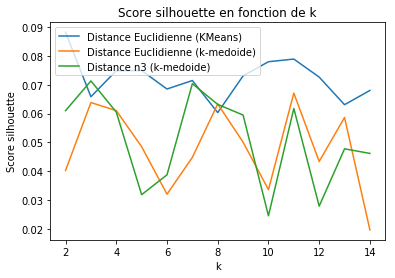

In [5]:
#Ensemble de donné réduit pour faire des tests
x__test= x_test[0:500]

# Définie une matrice des distances avec la métrique de notre choix
m_eucli = pairwise_distances(x__test, metric='euclidean')
m_n3 = pairwise_distances(x__test, metric=metric_n3)

scores = []
scores_t=[]
scores_n3=[]
k_range = range(2,15)
for k in k_range:
    y_pred = KMeans(n_clusters=k).fit_predict(x__test)
    scores.append(silhouette_score(x__test, y_pred))
    
    y_pred_t = k_medoid(m_eucli, k)
    scores_t.append(silhouette_score(x__test, y_pred_t))
    
    y_pred_n3 = k_medoid(m_n3, k)
    scores_n3.append(silhouette_score(x__test, y_pred_n3))

plt.plot(k_range, scores, label='Distance Euclidienne (KMeans)')
plt.plot(k_range, scores_t, label='Distance Euclidienne (k-medoide)')
plt.plot(k_range, scores_n3, label='Distance n3 (k-medoide)')
plt.legend(loc='upper left')
plt.xlabel('k')
plt.ylabel('Score silhouette')
plt.title('Score silhouette en fonction de k')

## 2) Partition binaire

Text(0.5,1,'Score silhouette en fonction de k')

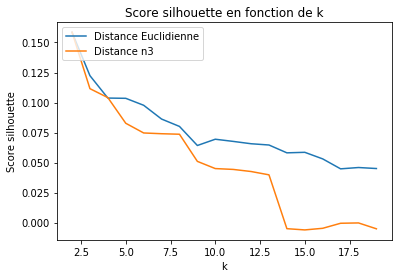

In [6]:
# Définie une matrice des distances avec la métrique de notre choix
m = pairwise_distances(x__test, metric=metric_n3)

scores = []
scores_t=[]
k_range = range(2,20)
for k in k_range:
    y_pred = AgglomerativeClustering(affinity='euclidean', linkage='average', n_clusters=k).fit_predict(x__test)
    scores.append(silhouette_score(x__test, y_pred))
    y_pred_t = AgglomerativeClustering(affinity='precomputed', linkage='average', n_clusters=k).fit_predict(m)
    scores_t.append(silhouette_score(x__test, y_pred_t))
plt.plot(k_range, scores, label='Distance Euclidienne')
plt.plot(k_range, scores_t, label='Distance n3')
plt.legend(loc='upper left')
plt.xlabel('k')
plt.ylabel('Score silhouette')
plt.title('Score silhouette en fonction de k')

# Réduction de dimensionnalité
------------
## 1) PCoA

On peut d'abord visualiser la réduction qu'effectue l'algorithme PCoA en se basant sur la métrique euclidienne et notre métrique.

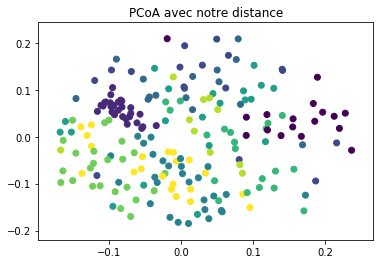

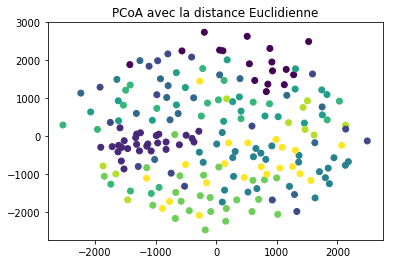

In [9]:
from sklearn.manifold import MDS
x = x_test[0:200]
y = y_test[0:200]
m = pairwise_distances(x, metric=metric_n3)
x_reducedN3 = MDS(n_components= 2, dissimilarity ='precomputed').fit_transform(m)
x_reducedEuc = MDS(n_components= 2).fit_transform(x)

plt.figure()  
plt.title('PCoA avec notre distance')
plt.scatter(x_reducedN3[:,0],x_reducedN3[:,1] , c=y, alpha=1)
plt.figure()   

plt.title('PCoA avec la distance Euclidienne')
plt.scatter(x_reducedEuc[:,0],x_reducedEuc[:,1] , c=y, alpha=1)

On effectue une **réduction de dimensionnalité** à l'aide du PCoA en utilisant les deux métriques. 
Puis on applique le même algorithme de classification (KNN) sur ces deux jeux de données "réduits".
On peut ainsi comparer le score de classification de données "réduites" selon deux notions de similarité différentes.

Text(0.5,1,'Score de classification en fonction des dimensions k')

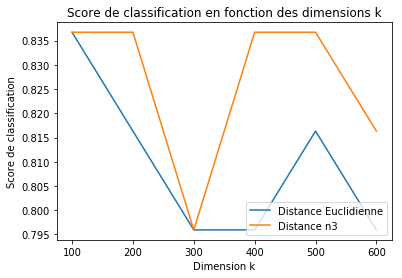

In [11]:
# Calcul de la matrice de distance des données avec notre métrique
m = pairwise_distances(x_train[:500], metric=metric_n3)

score_euc = []
score_n3  = []
dim_range = range(100,700,100)

for n in dim_range: 
    x__train = x_train[0:500].copy()
    y__train = y_train[0:500].copy()
    
    # PCoA euclidien
    mds = MDS(n_components=n)
    x__train_reduced = mds.fit_transform(x__train)
    knn = neighbors.KNeighborsClassifier(n_jobs=-1,n_neighbors=6,weights='uniform')
    knn.fit(x__train_reduced[:400], y__train[:400])
    
    score_euc.append(knn.score(x__train_reduced[451:500],y__train[451:500]))

    # PCoA avec métrique n3    
    x_train_pcoa_reduced = MDS(n_components= n, dissimilarity ='precomputed').fit_transform(m)

    knn1 = neighbors.KNeighborsClassifier(n_jobs=-1,n_neighbors=6,weights='uniform')
    knn1.fit(x_train_pcoa_reduced[:400], y__train[:400])

    score_n3.append(knn1.score(x_train_pcoa_reduced[451:500],y__train[451:500]))
    
# Affichage
plt.figure()
plt.plot(dim_range, score_euc, label=('Distance Euclidienne'))
plt.plot(dim_range, score_n3, label=('Distance n3'))
plt.legend(loc='lower right')
plt.xlabel('Dimension k')
plt.ylabel('Score de classification')
plt.title('Score de classification en fonction des dimensions k')

## Algorithme Isomap

Definir la fonction Isomap avec notre notion de Distance

In [29]:
from sklearn.neighbors import NearestNeighbors, kneighbors_graph
from sklearn.utils.graph import graph_shortest_path
from matplotlib.pyplot import scatter
from sklearn.manifold import Isomap

 #isomap avec notre distance propre x:donée k:n_neighbors n:n_components
def myIsomap(x,k,n):
    #calculer le distance avec notre propre notation de distance
    x_dist = pairwise_distances(x, metric=metric_n3)
    kng = kneighbors_graph(x_dist,n_neighbors=k, mode='distance',metric=metric_n3)
    #caculer le plus court chemin
    distmatrix = graph_shortest_path(kng,directed=False,method ='D')
    isomap=MDS(n_components=n,dissimilarity='precomputed')
    #isomap avec notre distance propre
    X_transformed = isomap.fit_transform(distmatrix)
    return X_transformed



On effectue une **réduction de dimensionnalité** à l'aide de Isomap en utilisant les deux métriques. 
Puis on applique le même algorithme de classification (KNN) sur ces deux jeux de données "réduits".
On peut ainsi comparer le score de classification de données "réduites" selon deux notions de similarité différentes.


Comparer le performance en utilisant knn classification avec différent k(nombre de voisin)

In [31]:
#préparer des donnéé
xtest = x_test[0:50]
y__test = y_test[0:50]
x__train = x_train[0:300]
y__train = y_train[0:300]
#compresser x__train avec isomap Euclidienne
mds = MDS(n_components=300)
x__trainNew = mds.fit_transform(x__train)
knn = KNeighborsClassifier()
knn.fit(x__trainNew,y__train)
x__testNew = mds.fit_transform(xtest)

#évaluer le performance
print("score de isomap avec distance Euclidienne:",knn.score(x__testNew,y__test))

#compresser x__train avec isomap notre distance,utiliser diffirent k
for k in range(1,10):
    print("k:",k)
    x__MytrainNew = myIsomap(x__train,k,300)
    x__MytestNew = myIsomap(xtest,k,300)
    knn = KNeighborsClassifier()
    knn.fit(x__MytrainNew,y__train)

#évaluer le performance
    print("score de isomap avec notre distance :",knn.score(x__MytestNew,y__test))


score de isomap avec distance Euclidienne: 0.14
k: 1
score de isomap avec notre distance : 0.1
k: 2
score de isomap avec notre distance : 0.16
k: 3
score de isomap avec notre distance : 0.1
k: 4
score de isomap avec notre distance : 0.14
k: 5
score de isomap avec notre distance : 0.14
k: 6
score de isomap avec notre distance : 0.1
k: 7
score de isomap avec notre distance : 0.08
k: 8
score de isomap avec notre distance : 0.08
k: 9
score de isomap avec notre distance : 0.08


La performance dépend aussi de hypermètre k .

Comparons les performances en utilisant **cross_validation**.

In [28]:
from sklearn.model_selection import cross_val_score

x = x_test[0:1000]

#compresser x__train avec isomap Euclidienne
mds = MDS(n_components=300)
x__trainNew = mds.fit_transform(x__train)
knn = KNeighborsClassifier()
knn.fit(x__trainNew,y__train)
x__testNew = mds.fit_transform(xtest)
#evaluer le performance
scoresMds = cross_val_score(knn, x__trainNew,y__train, cv=5,scoring='accuracy')
print("score moyenne de isomap avec Euclidienne::",scoresMds.mean())

#compresser x__train avec isomap notre distance
x__MytrainNew = myIsomap(x__train,k,300)
x__MytestNew = myIsomap(xtest,k,300)
knn = KNeighborsClassifier()
knn.fit(x__MytrainNew,y__train)
scoresMyIsomap = cross_val_score(knn, x__MytrainNew,y__train, cv=5,scoring='accuracy')
print("score moyenne de isomap avec notre propre distance::",scoresMyIsomap.mean())

score moyenne de isomap avec Euclidienne:: 0.788110613868581
score moyenne de isomap avec notre propre distance:: 0.8215091680102962


Le score moyen de Isomap utilisant notre métrique est **légérement plus élevé** que celui utilisant la métrique euclidienne.

# Prédiction
------------
## 1) KNN (Plus Proches Voisins)

0.925
1
0.875
1


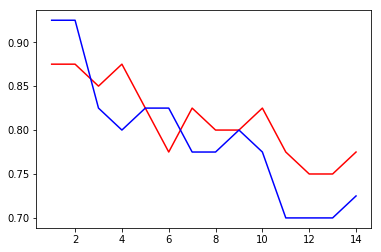

In [30]:
from sklearn.model_selection import train_test_split

x__train = x_train[0:200]
y__train = y_train[0:200]

X_train, X_test, Y_train, Y_test = train_test_split(x__train, y__train, test_size=0.2, stratify=y__train, random_state=0)

score_n3 = []
score_val = []
for k in np.arange(1, 15):
    clf = neighbors.KNeighborsClassifier(n_neighbors=k)
    clf.fit(X_train, Y_train)
    score_val.append(clf.score(X_test, Y_test))  
    
    clf_n3 = neighbors.KNeighborsClassifier(n_neighbors=k, metric = metric_n3)
    clf_n3.fit(X_train, Y_train)
    score_n3.append(clf_n3.score(X_test, Y_test))
    
plt.plot(np.arange(1, 15), score_n3, color='red')
plt.plot(np.arange(1, 15), score_val, color='blue')

print(np.max(score_val))
print(np.argmax(score_val)+1)
print(np.max(score_n3))
print(np.argmax(score_n3)+1)

La **taux de succès de la classification** utilisant notre métrique (courbe rouge) oscille autour de celui utilisant la métrique euclidienne (courbe bleue). 

Cela dit, on remarque que notre métrique donne de meilleurs résultats lorsque l'on se trouve aux alentours du **vrai k** soit 10 (c'est à dire les 10 classes (0 à 9) dont nous connaissons l'existence).

### Conclusion :
Notre notion de similarité semble efficace mais la différence est minime dans certains cas.

Force:<br>
     1.peu sensible à la translation de l'image (j'en parle au début du fichier) .<br>
     2.bien adapté à mnist car prend en compte la corrélation entre les pixels dus à l'intensité de noir
     
Faiblesses : <br>
     1.approximatif pour certains algorithmes approximatif car 2 images se ressemblant auront presque la même distance Même si          elles appartiennent à des classes différentes


